# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [4]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# 데이터 불러오기
book_data = pd.DataFrame()
df = pd.read_csv('data\detail_bestbook_review.csv', encoding="utf-8")
book_data = pd.concat([book_data,df])

In [7]:
# 코드 확인
print(book_data.head())

          ISBN13  rating                                             review
0  8809474876010      10                배송빠르고..가성비 좋네요.. 진짜 다이어리가 2개가 왔네요 .
1  8809474876010      10  주문한 다음날 오전에 받았어요. 배송 진짜 빠름빠름. 다이어리 대만족! 표지만 살짝...
2  8809474876003      10                             2개 세트는 아니었지만 양장에 퀄리티 굿
3  8809474876003      10  군더더기없이 깔끔하고 하나는 양장이고, 하나는 일반입니다. 2개세트라 내년까지 쓸수...
4  8809474876003      10  깔끔하고 심플하고, A5사이즈로 적당하고 양장인데 잘 펼쳐지고 종이 질도 매끔한거 ...


<AxesSubplot:>

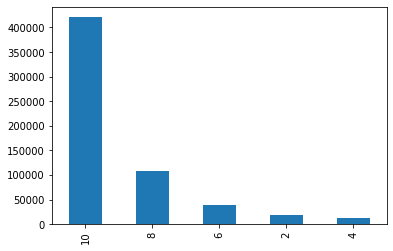

In [8]:
# 점수별 그래프
book_data['rating'].value_counts().plot(kind = 'bar')

## <전처리>

In [9]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

In [10]:
print(type(book_data.iloc[0]['review']))
print(cleansing(str(book_data.iloc[0]['review'])))
print(cleansing(book_data.iloc[0]['review']))
print(cleansing('배송빠르고..가성비 좋네요.. 진짜 다이어리가 2개가 왔네요 .'))

<class 'str'>
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 


In [40]:
# 전처리

book_data.drop_duplicates(subset=["review"], inplace=True)
book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
 # 정규 표현식을 통한 한글 외 문자 제거
book_data["review"] = [cleansing(str(text)) for text in book_data["review"]]
book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# 코드 확인
print(book_data.head())

          ISBN13  rating                                             review
0  8809474876010      10                    배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
1  8809474876010      10  주문한 다음날 오전에 받았어요 배송 진짜 빠름빠름 다이어리 대만족 표지만 살짝 다른...
2  8809474876003      10                             2개 세트는 아니었지만 양장에 퀄리티 굿
3  8809474876003      10  군더더기없이 깔끔하고 하나는 양장이고 하나는 일반입니다 2개세트라 내년까지 쓸수 있...
4  8809474876003      10  깔끔하고 심플하고 A5사이즈로 적당하고 양장인데 잘 펼쳐지고 종이 질도 매끔한거 같...


In [41]:
print('전처리 후 테스트용 샘플의 개수 :',len(book_data))

print(book_data.isnull().values.any())
# book_data = book_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
# print(book_data.isnull().values.any())

전처리 후 테스트용 샘플의 개수 : 298322
False


In [42]:
print(book_data.isnull().values.any())

False


### ISBN을 기준으로 리뷰를 모은 뒤 재조합

In [11]:
# 전처리된 데이터 가져오기
book_data = redf = pd.read_csv('data/detail_bestbook_cleaning.csv', encoding="utf-8")

print(book_data.head())

          ISBN13  rating                                             review
0  8809474876010      10                    배송빠르고 가성비 좋네요 진짜 다이어리가 2개가 왔네요 
1  8809474876010      10  주문한 다음날 오전에 받았어요 배송 진짜 빠름빠름 다이어리 대만족 표지만 살짝 다른...
2  8809474876003      10                             2개 세트는 아니었지만 양장에 퀄리티 굿
3  8809474876003      10  군더더기없이 깔끔하고 하나는 양장이고 하나는 일반입니다 2개세트라 내년까지 쓸수 있...
4  8809474876003      10  깔끔하고 심플하고 A5사이즈로 적당하고 양장인데 잘 펼쳐지고 종이 질도 매끔한거 같...


In [12]:
# isbn_set 만들기
isbn_set = set([])
for i in range(0,len(book_data)) : 
    isbn_set.add(book_data.iloc[i]['ISBN13'])

print(len(isbn_set))

42559


In [21]:
new_book_data = pd.DataFrame(columns=['ISBN13', 'review']) # ISBN별로 리뷰를 저장한 dataframe

for isbn in isbn_set : 
    tmp_df = book_data[(book_data["ISBN13"]==isbn)]
#     print(tmp_df)
    tmp_str = ''
    for i in range(0,len(tmp_df)) : 
        tmp_str =  tmp_str + tmp_df.iloc[i]['review'] + ' '
    tmp_str = tmp_str.strip()
    tmp_list=[isbn,tmp_str]
    new_book_data = new_book_data.append(pd.Series(tmp_list, index=new_book_data.columns), ignore_index=True)
#     new_book_data = pd.concat([new_book_data,tmp_df])

print(new_book_data.head())

          ISBN13                                             review
0  9788959752195                                      내가제일좋아하는책이당 6
1  9791136202772  처음 제목 보고 예상했던 스토리와 완전 다른데 너무 좋네요  우연히 본 신간을 홀린...
2  9791127420949  덕분에 귀여운 SD를 그릴 수 있게 되어서 너무 기쁩니다 별 5개로도 사실 모자랄 ...
3  9791164383252  나오자마자 구매해서 읽는데 30분 걸린 것 같아요 1권부터 쭉 읽고 있어요 그런데 ...
4  9788995797020  요가의 궁극적인 의미와 요가 수행자를 위한 메시지와 방법 과정을 알 수 있어요 자세...


In [24]:
tmp = new_book_data[(new_book_data["ISBN13"]==9788959137015)]['review']
print(tmp)

13335    그림체가 제 스타일이라 주저없이 구매했어요 역시나 재밌고 귀여움  마조앤새디 소장 ...
Name: review, dtype: object


In [29]:
# null 있는지 확인
print(new_book_data.isnull().values.any())

False


In [25]:
# isbn13 단위로 리뷰를 모은 DF 저장
new_book_data.to_csv(f'data/detail_bestbook_unit_isbn.csv', index=False)

## <토큰화>

In [62]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '것','라고','에게','라면','게','을','이라','라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있',
             '죠','고','니','로','있','같','어서','어요','는데','습니다','면서','많이','마','더']


In [30]:
# 도서 train 데이터 토큰화 - 명사 단위

okt = Okt()
book_train_X = []

for sentence in new_book_data['review']:
    temp_X = []
    # temp_X = okt.morphs(sentence, stem=True) # 형태소 단위로 토큰화
    temp_X = okt.nouns(sentence) # 명사 단위로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    # print(temp_X)
    if temp_X : 
        book_train_X.append(temp_X) #빈 list는 추가X

print('END')
print(book_train_X[:50])

END
[['가제', '일', '책', '당'], ['처음', '제목', '보고', '예상', '스토리', '완전', '신간', '홀린', '듯', '장바구니', '이제야', '사서', '정말', '맘', '진작', '사서', '볼', '걸', '조금', '여자', '이야기'], ['덕분', '그릴', '수', '별', '개', '사실', '정도', '책', '채색', '채색', '책', '별', '기대', '생각', '내용', '두고두고', '볼'], ['구매', '권', '쭉', '지리', '여행', '저희', '여행', '가기', '전', '닷'], ['요가', '궁극', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '알', '수', '자세', '설명', '정리', '매우', '서적', '요가', '공부', '위해', '구입', '공부', '도움', '요가', '교과서', '말', '요가', '대한', '백과사전', '명작', '설명', '그림', '첨부', '재미', '실제', '응용', '위', '참고서', '로서', '아헹', '선생님', '요가', '책', '알라딘', '쿠폰', '무료', '배송', '보아', '요가', '대한', '교과서', '최고', '요가', '책', '입문', '로서', '무리'], ['기본', '테니스', '스킬', '개', '관할', '수'], ['한국사', '강의', '추천', '구입', '초등', '교사', '사회', '역사', '수업', '자료', '사용', '내용', '역사', '속', '아이', '활약', '정리'], ['외과', '지원', '인턴', '의대', '생', '법', '병원', '사생활', '개인', '항해', '일지', '던', '글', '말', '더', '제목', '삽화가', '조금', '더', '일기', '그', '문장', '모', '의사', '낙서'], ['신심'], ['그린', '이의', '애정', '곤충', '움', '책', '우리나라', '사계절', '곤

In [ ]:
okt = Okt()
book_pos_X = []

for sentence in new_book_data['review']:
    temp_X = []
    # temp_X = okt.morphs(sentence, stem=True) # 형태소 단위로 토큰화
    temp_X = okt.nouns(sentence) # 명사 단위로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    # print(temp_X)
    if temp_X : 
        book_train_X.append(temp_X) #빈 list는 추가X

print('END')
print(book_train_X[:50])

In [31]:
# 저장하기
df = pd.DataFrame(book_train_X)
df.to_csv(f'data/detail_bestbook_unit_isbn_nouns.csv', index=False)

In [60]:
# 명사 토큰화 데이터 txt로 저장
import pickle

with open('data/detail_bestbook_nouns.txt','wb') as lf :
    pickle.dump(book_train_X,lf)

In [61]:
with open('data/detail_bestbook_nouns.txt', 'rb') as lf:
    readList = pickle.load(lf)
    print(readList[:5])

[['배송', '가성', '비', '진짜', '다이어리', '개'], ['주문', '다음', '날', '오전', '배송', '진짜', '다이어리', '만족', '표지', '살짝', '하나', '더', '권', '세트', '완전', '득템'], ['개', '세트', '양장', '퀄리티', '굿'], ['군더더기', '하나', '양장', '하나', '일반', '개', '세트', '내년', '쿠폰', '무료', '배송'], ['심플', '사이즈', '양장', '종이', '질도', '매', '거', '내년', '거', '보고', '걸', '정착']]


#### 분류 테스트 

In [36]:
# 분류 테스트


tmp_nouns = okt.nouns('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화')
tmp_morphs = okt.morphs('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화')

print(tmp_nouns)
print(tmp_morphs)

['공감', '웃음', '마', '조앤', '책', '더', '만화']
['많이', '공감', '과', '웃음', '을', '안기는', '마', '조앤', '새디', '책', '으로', '보면', '더', '재미있는', '만화']


In [49]:
# 분류 테스트

tmp_nouns = okt.nouns('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화')
# tmp_nouns = [word for word in tmp_nouns if not word in stopwords] # 불용어 제거
print('명사 > '+str(tmp_nouns))

tmp_morphs = okt.morphs('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화')
# tmp_morphs = [word for word in tmp_morphs if not word in stopwords] # 불용어 제거
print('형태소 > ' + str(tmp_morphs))

tmp_phrases = okt.phrases('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화')
# tmp_phrases = [word for word in tmp_phrases if not word in stopwords] # 불용어 제거
print('어구 > '+ str(tmp_phrases))

print(okt.pos('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화'))


print(okt.pos('재미있다'))
tmp = okt.nouns('재미있다')
print(tmp)
tmp = okt.nouns('재밌었다')
print(tmp)
tmp = okt.morphs('재미있다')
print(tmp)
tmp = okt.phrases('재미있다')
print(tmp)

print(okt.pos('반등했다'))
tmp = okt.nouns('반등했다')
print(tmp)
tmp = okt.morphs('반등했다')
print(tmp)
tmp = okt.phrases('반등했다')
print(tmp)

명사 > ['공감', '웃음', '마', '조앤', '책', '더', '만화']
형태소 > ['많이', '공감', '과', '웃음', '을', '안기는', '마', '조앤', '새디', '책', '으로', '보면', '더', '재미있는', '만화']
어구 > ['공감', '공감과 웃음', '마조앤', '더 재미있는 만화', '웃음', '조앤', '만화']
[('많이', 'Adverb'), ('공감', 'Noun'), ('과', 'Josa'), ('웃음', 'Noun'), ('을', 'Josa'), ('안기는', 'Verb'), ('마', 'Noun'), ('조앤', 'Noun'), ('새디', 'Verb'), ('책', 'Noun'), ('으로', 'Josa'), ('보면', 'Verb'), ('더', 'Noun'), ('재미있는', 'Adjective'), ('만화', 'Noun')]
[('재미있다', 'Adjective')]
[]
[]
['재미있다']
[]
[('반등', 'Noun'), ('했다', 'Verb')]
['반등']
['반등', '했다']
['반등']


In [70]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '것','라고','에게','라면','게','을','이라','라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있',
             '죠','고','니','로','있','같','어서','어요','는데','습니다','면서','많이','마','더']


In [71]:
# 분류 테스트

tmp = []
tmp = okt.morphs('많이 공감과 웃음을 안기는 마조앤새디 책으로 보면 더 재미있는 만화', stem=True) # 형태소 단위로 토큰화
tmp = [word for word in tmp if not word in stopwords] # 불용어 제거

tmp_pos = []
tmp_non_pos = []
for word in tmp :
    pos = okt.pos(word)
    if pos[0][1]=='Noun' or pos[0][1]=='Adjective':
        tmp_pos.append(pos[0])
        tmp_non_pos.append(pos[0][0])

print(tmp_pos)
print(tmp_non_pos)


['공감', '웃음', '안기다', '조앤', '새다', '책', '보다', '재미있다', '만화']
[('공감', 'Noun'), ('웃음', 'Noun'), ('조앤', 'Noun'), ('책', 'Noun'), ('재미있다', 'Adjective'), ('만화', 'Noun')]
['공감', '웃음', '조앤', '책', '재미있다', '만화']


In [83]:
################ 명사랑 형용사 추출 

book_pos_X = []

print(len(new_book_data))
print('\n')

book_pos = []
book_pos_only_isbn = []
book_pos_with_isbn = []


for i in range(0,len(new_book_data)):
    isbn = new_book_data.iloc[i]['ISBN13']
    sentence = new_book_data.iloc[i]['review']
    tmp = []
    tmp = okt.morphs(sentence, stem=True) # 형태소 단위로 토큰화
    tmp = [word for word in tmp if not word in stopwords] # 불용어 제거
    
    tmp_non_pos = []
    for word in tmp :
        pos = okt.pos(word)
        if pos[0][1]=='Noun' or pos[0][1]=='Adjective':
            tmp_non_pos.append(pos[0][0])
    if tmp_non_pos : 
        book_pos_X.append(tmp_non_pos)
        book_pos_only_isbn.append(isbn)
        book_pos_with_isbn.append([isbn,tmp_non_pos])
    
print(len(book_pos_X))

42559


42513


In [85]:
print(book_pos_X[:10])

[['내', '가제', '일', '좋아하다', '책', '당'], ['처음', '제목', '보고', '예상', '스토리', '완전', '다르다', '좋다', '신간', '홀린', '듯', '장바구니', '이제야', '사서', '정말', '맘', '진작', '사서', '볼', '걸', '그렇다', '유쾌하다', '조금', '유치하다', '여자', '이야기'], ['덕분', '귀엽다', '그릴', '수', '기쁘다', '별', '개', '사실', '정도', '좋다', '책', '채색', '없다', '아쉽다', '채색', '책', '아니다', '별', '기대', '안', '생각', '내용', '알차다', '두고두고', '볼', '같다'], ['구매', '같다', '권', '부터', '쭉', '지리', '여행', '저희', '여행', '가기', '전', '닷'], ['요가', '궁극', '적', '인', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '알', '수', '자세', '설명', '알다', '쉬', '정리', '매우', '유익하다', '서적', '요가', '공부', '위해', '구입', '어렵다', '공부', '도움', '요가', '교과서', '말', '요가', '대한', '백과사전', '식', '명작', '자세하다', '설명', '그림', '첨부', '재미', '좋다', '실제', '응용', '위', '참고서', '로서', '훌륭하다', '아헹', '선생님', '요가', '책', '뿐', '알라딘', '쿠폰', '무료', '배송', '보아', '요', '요가', '대한', '교과서', '최고', '요가', '책', '입문', '로서', '무리', '없다'], ['기본', '적', '인', '테니스', '스킬', '개', '관할', '수'], ['한국사', '강의', '추천', '구입', '초등', '교사', '사회', '역사', '수업', '자료', '사용', '유용하다', '내용', '많다', '역사', '속', '아이', 

In [86]:
# 저장하기
df1 = pd.DataFrame(book_pos_X)
df1.to_csv(f'data/detail_bestbook_unit_isbn_pos.csv', index=False)

In [87]:
import pickle

with open('data/detail_bestbook_unit_isbn_pos.txt','wb') as lf :
    pickle.dump(book_pos_X,lf)

In [88]:
# 저장하기
df2 = pd.DataFrame(book_pos_with_isbn)
df2.to_csv(f'data/detail_bestbook_unit_isbn_pos(with.isbn).csv', index=False)

In [95]:
## 품사 태깅 데이터 셋 - 불용어 처리X

# test_df = new_book_data[:10]

book_morphs_with_isbn_pos_non_stopword = []

for i in range(0,len(new_book_data)):
    isbn = new_book_data.iloc[i]['ISBN13']
    sentence = new_book_data.iloc[i]['review']
    tmp = []
    tmp = okt.morphs(sentence, stem=True) # 형태소 단위로 토큰화
#     tmp = [word for word in tmp if not word in stopwords] # 불용어 제거
    
    if tmp :
        tmp_non_pos = []
        for word in tmp :
            pos = okt.pos(word)
            tmp_non_pos.append(pos[0])
        if tmp_non_pos : 
#             print(tmp_non_pos)
            book_morphs_with_isbn_pos_non_stopword.append([isbn,tmp_non_pos])

print(len(book_morphs_with_isbn_pos))

991


In [98]:
print(len(book_morphs_with_isbn_pos_non_stopword))

print(book_morphs_with_isbn_pos_non_stopword[10])

42559
[9788974825515, [('아이', 'Noun'), ('에게', 'Josa'), ('중국어', 'Noun'), ('에', 'Josa'), ('대한', 'Noun'), ('자신감', 'Noun'), ('을', 'Josa'), ('실어', 'Noun'), ('줄', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('책', 'Noun'), ('인', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective'), ('열심히', 'Adverb'), ('공부', 'Noun'), ('하다', 'Verb'), ('자격증', 'Noun'), ('을', 'Josa'), ('따다', 'Verb'), ('중국어', 'Noun'), ('와', 'Verb'), ('더', 'Noun'), ('가깝다', 'Adjective'), ('지다', 'Noun'), ('하다', 'Verb')]]


In [97]:
# 불용어 제거X, ISBN, 품사 태깅 저장하기
df1 = pd.DataFrame(book_pos_X)
df1.to_csv(f'data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.csv', index=False)

In [99]:
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt','wb') as lf :
    pickle.dump(book_morphs_with_isbn_pos_non_stopword,lf)

In [100]:
# 불러오기

readList = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    readList = pickle.load(lf)
    
print(readList[0])

[[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]], [9791136202772, [('처음', 'Noun'), ('제목', 'Noun'), ('보고', 'Noun'), ('예상', 'Noun'), ('하다', 'Verb'), ('스토리', 'Noun'), ('와', 'Verb'), ('완전', 'Noun'), ('다르다', 'Adjective'), ('너무', 'Adverb'), ('좋다', 'Adjective'), ('우연히', 'Adverb'), ('보다', 'Verb'), ('신간', 'Noun'), ('을', 'Josa'), ('홀린', 'Noun'), ('듯', 'Noun'), ('장바구니', 'Noun'), ('에', 'Josa'), ('담다', 'Verb'), ('놓다', 'Verb'), ('이제야', 'Noun'), ('사서', 'Noun'), ('읽다', 'Verb'), ('정말', 'Noun'), ('맘', 'Noun'), ('에', 'Josa'), ('들다', 'Verb'), ('진작', 'Noun'), ('사서', 'Noun'), ('볼', 'Noun'), ('걸', 'Noun'), ('그렇다', 'Adjective'), ('유쾌하다', 'Adjective'), ('조금', 'Noun'), ('은', 'Noun'), ('유치하다', 'Adjective'), ('여자', 'Noun'), ('들', 'Verb'), ('의', 'Noun'), ('이야기', 'Noun')]], [9791127420949, [('덕분', 'Noun'), ('에', 'Josa'), ('귀엽다', 'Adjective'), ('SD', 'Alpha'), ('를', 'Noun'), ('그릴', 'Noun'), ('수', 'Noun'), ('있다', 'Adj

In [104]:
print(readList[4][1])

[('요가', 'Noun'), ('의', 'Noun'), ('궁극', 'Noun'), ('적', 'Noun'), ('인', 'Noun'), ('의미', 'Noun'), ('와', 'Verb'), ('요가', 'Noun'), ('수행자', 'Noun'), ('를', 'Noun'), ('위', 'Noun'), ('한', 'Verb'), ('메시지', 'Noun'), ('와', 'Verb'), ('방법', 'Noun'), ('과정', 'Noun'), ('을', 'Josa'), ('알', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('자세', 'Noun'), ('설명', 'Noun'), ('도', 'Noun'), ('알다', 'Noun'), ('쉬', 'Noun'), ('정리', 'Noun'), ('되어다', 'Verb'), ('따르다', 'Verb'), ('익히다', 'Verb'), ('매우', 'Noun'), ('유익하다', 'Adjective'), ('서적', 'Noun'), ('이다', 'Josa'), ('요가', 'Noun'), ('공부', 'Noun'), ('를', 'Noun'), ('위해', 'Noun'), ('구입', 'Noun'), ('하다', 'Verb'), ('아직', 'Adverb'), ('어렵다', 'Adjective'), ('자다', 'Verb'), ('모르다', 'Verb'), ('공부', 'Noun'), ('하다', 'Verb'), ('도움', 'Noun'), ('이', 'Noun'), ('많이', 'Adverb'), ('되다', 'Verb'), ('요가', 'Noun'), ('의', 'Noun'), ('교과서', 'Noun'), ('라', 'Josa'), ('말', 'Noun'), ('하다', 'Verb'), ('하다', 'Verb'), ('요가', 'Noun'), ('에', 'Josa'), ('대한', 'Noun'), ('백과사전', 'Noun'), ('식', 'Noun'), ('명작', 'Noun

In [115]:
# 품사 있는 데이터 버리기
tt = book_morphs_with_isbn_pos_non_stopword[1][1]
print(tt)
print()
tts = []
tts = [word for (word,pos) in tt if not word in stopwords]

print(tts)



[('처음', 'Noun'), ('제목', 'Noun'), ('보고', 'Noun'), ('예상', 'Noun'), ('하다', 'Verb'), ('스토리', 'Noun'), ('와', 'Verb'), ('완전', 'Noun'), ('다르다', 'Adjective'), ('너무', 'Adverb'), ('좋다', 'Adjective'), ('우연히', 'Adverb'), ('보다', 'Verb'), ('신간', 'Noun'), ('을', 'Josa'), ('홀린', 'Noun'), ('듯', 'Noun'), ('장바구니', 'Noun'), ('에', 'Josa'), ('담다', 'Verb'), ('놓다', 'Verb'), ('이제야', 'Noun'), ('사서', 'Noun'), ('읽다', 'Verb'), ('정말', 'Noun'), ('맘', 'Noun'), ('에', 'Josa'), ('들다', 'Verb'), ('진작', 'Noun'), ('사서', 'Noun'), ('볼', 'Noun'), ('걸', 'Noun'), ('그렇다', 'Adjective'), ('유쾌하다', 'Adjective'), ('조금', 'Noun'), ('은', 'Noun'), ('유치하다', 'Adjective'), ('여자', 'Noun'), ('들', 'Verb'), ('의', 'Noun'), ('이야기', 'Noun')]

['처음', '제목', '보고', '예상', '스토리', '완전', '다르다', '너무', '좋다', '우연히', '보다', '신간', '홀린', '듯', '장바구니', '담다', '놓다', '이제야', '사서', '읽다', '정말', '맘', '들다', '진작', '사서', '걸', '유쾌하다', '조금', '유치하다', '여자', '이야기']


In [190]:
# 품사 있는 데이터 버리기
index = 25498
print(book_morphs_with_isbn_pos_non_stopword[index][0])

sentence = new_book_data.iloc[index]['review']
# tmp = okt.morphs(sentence)
# print(tmp)

test = book_morphs_with_isbn_pos_non_stopword[index][1]
print(test)
print()

tts = []
tts = [(word,pos) for (word,pos) in test if not word in stopwords]
print(tts)
print()


# na = ['Noun','Adjective']

tt = [(word,pos) for (word,pos) in tts if pos in 'Noun']
na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장
for (word,pos) in tts : #형용사 : 길이가 1이상
    if pos == 'Adjective' and len(word)>1 :
        tt.append((word,pos))
        na.append(word)


print(tt)
print(na)

9788956553009
[('영문', 'Noun'), ('명작', 'Noun'), ('선', 'Noun'), ('이다', 'Josa'), ('영어', 'Noun'), ('에', 'Josa'), ('재미', 'Noun'), ('를', 'Noun'), ('붙이', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective')]

[('영문', 'Noun'), ('명작', 'Noun'), ('선', 'Noun'), ('영어', 'Noun'), ('재미', 'Noun')]

[('영문', 'Noun'), ('명작', 'Noun'), ('선', 'Noun'), ('영어', 'Noun'), ('재미', 'Noun')]
['영문', '명작', '선', '영어', '재미']


d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [187]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내']

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
######### 태깅한 데이터 중에서 명사 + 형용사(1이상) + 불용어 처리

book_train_nouns_adj = []
book_train_na_with_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
#     print(isbn)
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리

#     tt = [(word,pos) for (word,pos) in tts if pos in 'Noun'] # 태깅데이터 포함
    na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장
    for (word,pos) in tts : #형용사 : 길이가 1이상
        if pos == 'Adjective' and len(word)>1 :
            tt.append((word,pos))
#             na.append(word)
    if na : 
        book_train_nouns_adj.append(na)
#         book_na_tag.append(tt)
        book_train_na_with_isbn.append([isbn,na])

print('**********************END***************************')

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**********************END***************************


In [163]:
print(book_train_nouns_adj[0])
print(book_train_na_with_isbn[0])

['내', '일']
[9788959752195, ['내', '일']]


In [164]:
####### ISBN + 불용어, N, A > 1
# 저장하기
df = pd.DataFrame(book_train_na_with_isbn)
df1.to_csv(f'data/detail_bestbook_unit_isbn_NA(with.isbn).csv', index=False)

In [165]:
with open('data/detail_bestbook_unit_isbn_NA(with.isbn).txt','wb') as lf :
    pickle.dump(book_morphs_with_isbn_pos_non_stopword,lf)

In [43]:
test = [1]
if test : 
    print("test")
if not test :
    print('not')

test


# 정수 인코딩과 단어 집합 만들기

(인코딩값, 빈도수)

#### 데이터 셋
* 명사
* 형용사 길이 > 1

In [166]:
from gensim import corpora


dictionary = corpora.Dictionary(book_train_nouns_adj)
corpus = [dictionary.doc2bow(text) for text in book_train_nouns_adj]
# print(corpus[513]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0

[(6, 1), (30, 1), (36, 1), (57, 1), (64, 1), (68, 1), (78, 1), (183, 1), (206, 1), (246, 1), (263, 1), (294, 1), (314, 1), (318, 1), (437, 1), (494, 1), (495, 1), (543, 1), (552, 2), (561, 1), (641, 1), (730, 1), (987, 2), (1396, 1), (1557, 1), (1654, 1), (1706, 1), (1911, 1), (1919, 1), (1926, 1), (2093, 1), (2357, 1), (2453, 1), (2854, 1), (2996, 1), (4130, 1), (4423, 2), (4468, 1), (5584, 1), (5585, 1), (5586, 2), (5587, 1), (5588, 1), (5589, 1), (5590, 1), (5591, 1), (5592, 1)]


In [168]:
print(len(book_train_nouns_adj))
print(len(dictionary))
print(len(corpus))

42369
52760
42369


In [169]:
print(corpus[157])

[(11, 1), (36, 3), (43, 1), (88, 1), (90, 1), (94, 1), (182, 1), (198, 1), (206, 1), (228, 1), (314, 1), (328, 5), (426, 1), (536, 2), (544, 1), (849, 1), (891, 2), (1021, 1), (1278, 1), (1936, 1), (2229, 1), (2456, 1), (2475, 1), (2476, 1), (2477, 1), (2478, 1), (2479, 1), (2480, 1), (2481, 1), (2482, 1), (2483, 1)]


In [171]:
print(dictionary[328])
print(dictionary[536])

한자
복습


# LDA 모델 훈련시키기


passes는 알고리즘의 동작 횟수를 말하는데, 알고리즘이 결정하는 토픽의 값이 적절히 수렴할 수 있도록 충분히 적당한 횟수를 정해주면 됩니다. 
여기서는 총 15회를 수행

In [172]:
import gensim

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.026*"공부" + 0.016*"도움" + 0.015*"쉬" + 0.012*"영어"')
(1, '0.053*"아이" + 0.026*"그림" + 0.010*"엄마" + 0.007*"보고"')
(2, '0.026*"적" + 0.012*"대한" + 0.011*"생각" + 0.010*"역사"')
(3, '0.020*"생각" + 0.016*"사람" + 0.014*"나" + 0.013*"적"')
(4, '0.022*"소설" + 0.017*"작품" + 0.015*"작가" + 0.013*"권"')


## 시각화


In [173]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [74]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.30006546), (1, 0.014294099), (2, 0.014291131), (3, 0.1570159), (4, 0.014291131), (5, 0.014291131), (6, 0.01429433), (7, 0.15718687), (8, 0.29997322), (9, 0.014296708)]
1 번째 문서의 topic 비율은 [(0, 0.3884414), (3, 0.3679789), (6, 0.20238101)]
2 번째 문서의 topic 비율은 [(0, 0.3501626), (1, 0.016682936), (2, 0.016682936), (3, 0.18336561), (4, 0.016682936), (5, 0.016682936), (6, 0.1828772), (7, 0.18349701), (8, 0.016682936), (9, 0.016682936)]
3 번째 문서의 topic 비율은 [(0, 0.091721125), (3, 0.5087478), (6, 0.091096915), (7, 0.17508632), (9, 0.09163542)]
4 번째 문서의 topic 비율은 [(2, 0.08384413), (6, 0.32060724), (7, 0.19374393), (8, 0.08468219), (9, 0.27861086)]
d:\project02\field-team4_Test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_e